# Deep Recurrent Neural Networks

In [ ]:
using Pkg; Pkg.activate("../../d2lai")
using d2lai
using Flux 
using Downloads
using StatsBase
using Plots
using CUDA, cuDNN
import d2lai: GRUScratch

  Activating project at `/workspace/d2l-julia/d2lai`
[ Info: Precompiling d2lai [749b8817-cd67-416c-8a57-830ea19f3cc4] (cache misses: include_dependency fsize change (2))


In [2]:

struct StackedRNNScratch{N, A} <: AbstractModel 
    net::N 
    args::A 
end 

Flux.@layer StackedRNNScratch trainable = (net,)

function StackedRNNScratch(num_inputs, num_hiddens, num_layers; sigma = 0.01)
    layers = map(1:num_layers) do  i 
        if i == 1 
            return GRUScratch(num_inputs, num_hiddens; sigma)
        else
            return GRUScratch(num_hiddens, num_hiddens; sigma)
        end
    end
    StackedRNNScratch(layers, construct_nt_args(; num_inputs, num_hiddens, num_layers, sigma))
end


StackedRNNScratch

In [3]:
function (rnn::StackedRNNScratch)(x, state = nothing)
    states = isnothing(state) ? [nothing for _ in 1:length(rnn.net)] : state 
    new_states = []
    for (rnn, st_) in zip(rnn.net, states)
        x, new_st = rnn(x, st_)
        new_states = [new_states; [new_st]]
    end
    x, new_states
end


[ Info: Train Loss: 2.9601334558165466, Val Loss: 2.9517217666830966
[ Info: Train Loss: 3.083218267768948, Val Loss: 3.0733841376993163
[ Info: Train Loss: 2.8951596061949756, Val Loss: 2.8912486456702347
[ Info: Train Loss: 3.201351587714034, Val Loss: 3.175039186751496
[ Info: Train Loss: 2.718827714649281, Val Loss: 2.720499446484515
[ Info: Train Loss: 3.8262812256137186, Val Loss: 3.854138404494324
[ Info: Train Loss: 2.555370779938557, Val Loss: 2.5738663453725583
[ Info: Train Loss: 2.731417246063586, Val Loss: 2.733773122408332
[ Info: Train Loss: 2.71089042383076, Val Loss: 2.738603978195346
[ Info: Train Loss: 2.44044572594663, Val Loss: 2.462528609008958
[ Info: Train Loss: 2.3516735432179914, Val Loss: 2.4067911823277437
[ Info: Train Loss: 2.3687606868636766, Val Loss: 2.47717199329585
[ Info: Train Loss: 2.3588690160925685, Val Loss: 2.4418052758133952
[ Info: Train Loss: 2.237565755244201, Val Loss: 2.3642804555051993
[ Info: Train Loss: 2.235600284005974, Val Loss: 2.3

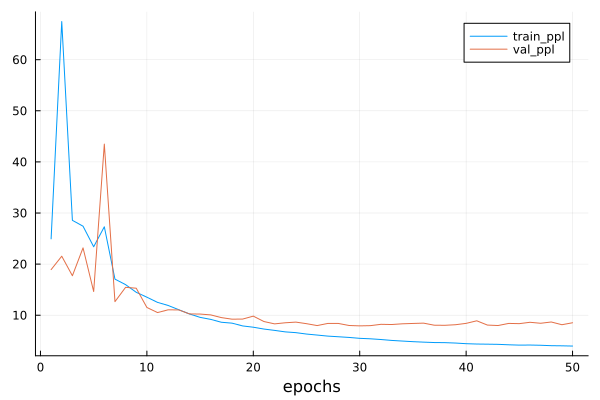

In [9]:
data = d2lai.TimeMachine(1024, 32) |> f64
num_hiddens = 32
num_layers = 2 
stacked_rnns = StackedRNNScratch(length(data.vocab), num_hiddens, 2)

model = RNNLMScratch(stacked_rnns, length(data.vocab)) |> f64

opt = Descent(4.)
trainer = Trainer(model, data, opt; max_epochs = 50, gpu = true, board_yscale = :identity, gradient_clip_val = 1.)
m, _ = d2lai.fit(trainer);


In [12]:
prefix = "it has"
d2lai.prediction(prefix, m, data.vocab, 20)


"it has explere and have no"

In [21]:
struct StackedRNN{N, A} <: AbstractModel 
    net::N 
    args::A 
end 
Flux.@layer StackedRNN trainable = (net,)
function StackedRNN(num_inputs, num_hiddens, num_layers)
    layers = map(1:num_layers) do i
        if i==1 
            return GRU(num_inputs => num_hiddens; return_state = true)
        else
            return GRU(num_hiddens => num_hiddens; return_state = true)
        end
    end
    StackedRNN(layers, construct_nt_args(; num_inputs, num_hiddens, num_layers))
end

function (rnn::StackedRNN)(x, state = nothing)
    states = isnothing(state) ? [Flux.initialstates(n) for n in rnn.net] : state 
    new_states = []
    for (m, st_) in zip(rnn.net, states)
        x, new_st = m(x, st_)
        new_states = [new_states; [new_st]]
    end
    x, new_states
end

[ Info: Train Loss: 3.0729582, Val Loss: 3.0826774
[ Info: Train Loss: 2.9488046, Val Loss: 2.9387672
[ Info: Train Loss: 2.8525553, Val Loss: 2.8506098
[ Info: Train Loss: 2.6630747, Val Loss: 2.6527565
[ Info: Train Loss: 2.5859373, Val Loss: 2.5650566
[ Info: Train Loss: 2.4740438, Val Loss: 2.514804
[ Info: Train Loss: 2.371892, Val Loss: 2.394975
[ Info: Train Loss: 2.354868, Val Loss: 2.4037442
[ Info: Train Loss: 2.254007, Val Loss: 2.3529797
[ Info: Train Loss: 2.2311308, Val Loss: 2.3084953
[ Info: Train Loss: 2.147948, Val Loss: 2.234294
[ Info: Train Loss: 2.0833817, Val Loss: 2.2096674
[ Info: Train Loss: 2.0624454, Val Loss: 2.2006884
[ Info: Train Loss: 2.0190148, Val Loss: 2.141577
[ Info: Train Loss: 1.9770054, Val Loss: 2.1524167
[ Info: Train Loss: 1.9207356, Val Loss: 2.123338
[ Info: Train Loss: 1.8788599, Val Loss: 2.0964837
[ Info: Train Loss: 1.8548547, Val Loss: 2.0287824
[ Info: Train Loss: 1.7822961, Val Loss: 2.0009334
[ Info: Train Loss: 1.7661173, Val Loss:

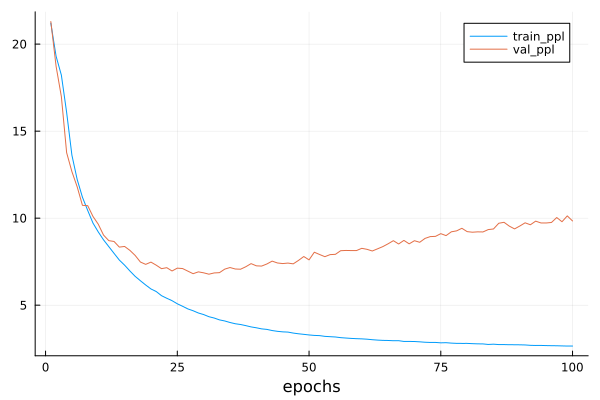

In [22]:
srnn = StackedRNN(length(data.vocab), num_hiddens, 2) |> f64
model = RNNModelConcise(srnn, num_hiddens, length(data.vocab)) |> f64

opt = Flux.Optimiser(Descent(2.))
trainer = Trainer(model, data, opt; max_epochs = 100, gpu = true, board_yscale = :identity, gradient_clip_val = 1.)
m, _ = d2lai.fit(trainer);


In [23]:
d2lai.prediction(prefix, m, data.vocab, 20)


"it has of staying is all r"